In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22
plt.rc('font', size=SMALL_SIZE, family = "Nimbus Roman")          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# load embeddings
dataset_name = "gowalla"
with open(f"pickles/lgn-predictions-{dataset_name}.pickle", "rb") as pickleFile:
    predictions = pickle.load(pickleFile)
m, d = predictions["item embeddings"].shape
n, _ = predictions["user embeddings"].shape
print(n, m, d)

29858 40981 64


In [7]:
# load interactions
item_popularities = {idx: 0 for idx in range(m)}

train_file = f"LightGCN/data/{dataset_name}/train.txt"
interactions = {}
with open(train_file) as f:
    for l in f.readlines():
        if len(l) > 0:
            l = l.strip('\n').split(' ')
            items = [int(i) for i in l[1:]]
            for idx in items:
                item_popularities[idx] += 1
            interactions[int(l[0])] = items

done
27.132694755174494


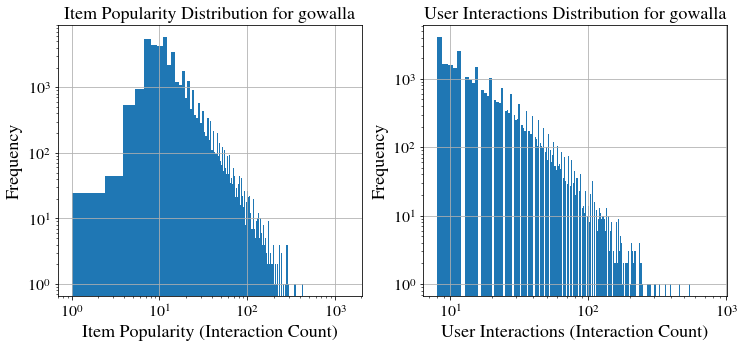

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
item_pop_list = np.array([item_popularities[idx] for idx in range(m)])
ax[0].hist(item_pop_list,
        bins = 1000)
ax[0].set_yscale("log")
ax[0].set_xscale("log")

ax[0].set_xlabel("Item Popularity (Interaction Count)")
ax[0].set_ylabel("Frequency")
ax[0].set_title(f"Item Popularity Distribution for {dataset_name}")
ax[0].grid()

user_frequency_list = np.array([len(interactions[idx]) for idx in range(n)]) #will break if a user is missing
ax[1].hist(user_frequency_list,
        bins = 1000)
ax[1].set_yscale("log")
ax[1].set_xscale("log")

ax[1].set_xlabel("User Interactions (Interaction Count)")
ax[1].set_ylabel("Frequency")
ax[1].set_title(f"User Interactions Distribution for {dataset_name}")
ax[1].grid()

print("done")
print(np.mean(user_frequency_list))

Text(0.5, 1.0, 'Item Embedding Norm by Popularity for gowalla')

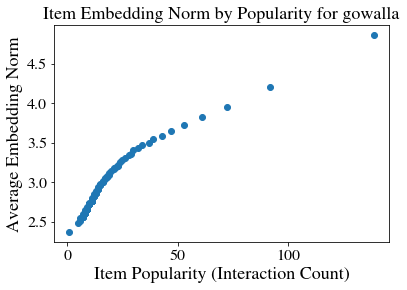

In [8]:
popularities = []
avg_norms = []
for percentile in np.arange(0, 100, 1):
    lower_bound = np.percentile(item_pop_list, percentile)
    upper_bound = np.percentile(item_pop_list, percentile + 1)
    
    indices = np.where((item_pop_list >= lower_bound) & (item_pop_list <= upper_bound))[0]
    norms = [np.linalg.norm(predictions["item embeddings"][idx]) for idx in indices]
    avg_norms.append(np.mean(norms))
    popularities.append(lower_bound)
    
fig, ax = plt.subplots()
ax.scatter(popularities, avg_norms)
ax.set_xlabel("Item Popularity (Interaction Count)")
ax.set_ylabel("Average Embedding Norm")
ax.set_title(f"Item Embedding Norm by Popularity for {dataset_name}")

Text(0.5, 1.0, 'amazon-book')

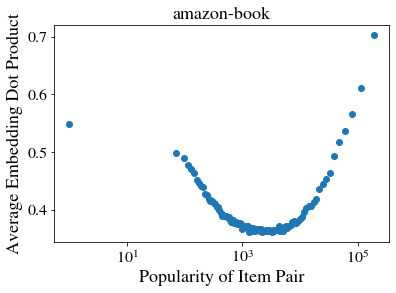

In [20]:
trials = 1000000
popularity_products = []
dot_products = []

users = list(interactions.keys())
rng = np.random.default_rng()
for _ in range(trials):
    user_id = users[rng.choice(len(users))]
    if len(interactions[user_id]) < 2:
        continue
    item_pair = rng.choice(interactions[user_id], size=2, replace=False)
    popularity_products.append(item_popularities[item_pair[0]] * item_popularities[item_pair[1]])
    
    v_i = predictions["item embeddings"][item_pair[0]]
    v_j = predictions["item embeddings"][item_pair[1]]
    dot_products.append(np.dot(v_i, v_j))
    dot_products[-1] /= (np.linalg.norm(v_i) * np.linalg.norm(v_j))

dot_products = np.array(dot_products)
pair_popularity_buckets = []
avg_dot_products = []
for percentile in np.arange(0, 100, 1):
    lower_bound = np.percentile(popularity_products, percentile)
    upper_bound = np.percentile(popularity_products, percentile + 1)
    
    indices = np.where((popularity_products >= lower_bound) & (popularity_products <= upper_bound))[0]
    avg_dot_products.append(np.mean(dot_products[indices]))
    pair_popularity_buckets.append(lower_bound)
    
fig, ax = plt.subplots()
ax.scatter(pair_popularity_buckets, avg_dot_products)
ax.set_xscale("log")
ax.set_xlabel("Popularity of Item Pair")
ax.set_ylabel("Average Embedding Dot Product")
ax.set_title(dataset_name)

## Cosine Similarity by Tau

100%|██████████| 500000/500000 [00:16<00:00, 29433.55it/s]


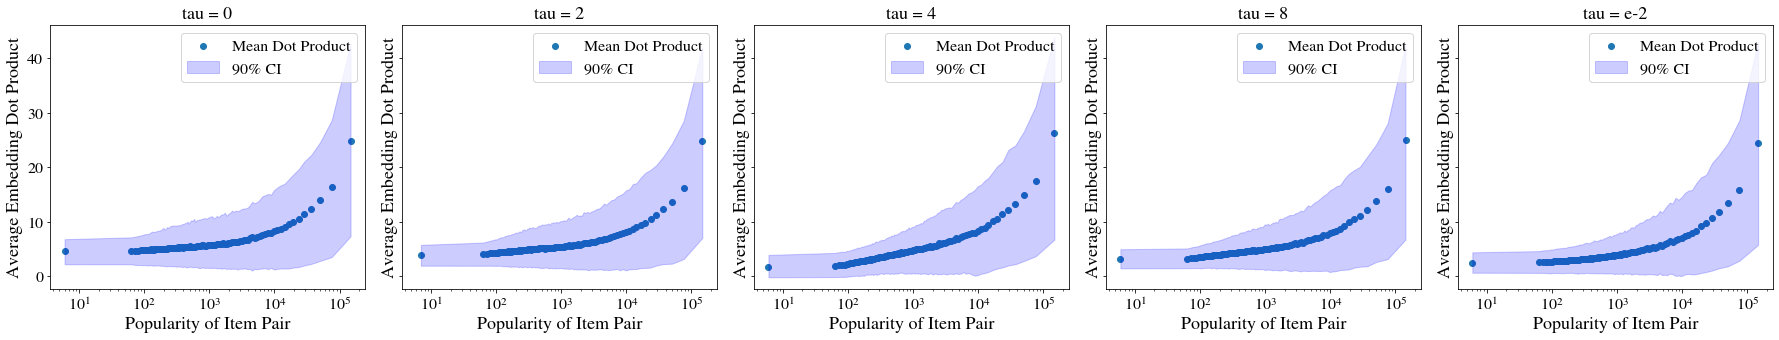

In [4]:
dataset_name = "gowalla"
with open(f"pickles/tau/lgn-predictions-{dataset_name}.pickle", "rb") as pickleFile:
    predictions = pickle.load(pickleFile)
m, d = predictions["0"]["item embeddings"].shape

# Load interactions
item_popularities = {idx: 0 for idx in range(m)}

train_file = f"LightGCN/data/{dataset_name}/train.txt"
interactions = {}
with open(train_file) as f:
    for l in f.readlines():
        if len(l) > 0:
            l = l.strip().split(' ')
            items = [int(i) for i in l[1:]]
            for idx in items:
                item_popularities[idx] += 1
            interactions[int(l[0])] = items

trials = 500000
fig, ax = plt.subplots(ncols=len(predictions), sharex=True, sharey=True, figsize=(5 * len(predictions), 5))

if len(predictions) == 1:
    ax = [ax]  # Ensure ax is always iterable

for ax_idx, tau in enumerate(predictions):
    popularity_products = []
    dot_products = []

    users = list(interactions.keys())
    rng = np.random.default_rng()
    for _ in tqdm(range(trials)):
        user_id = users[rng.choice(len(users))]
        if len(interactions[user_id]) < 2:
            continue
        item_pair = rng.choice(interactions[user_id], size=2, replace=False)
        popularity_products.append(item_popularities[item_pair[0]] * item_popularities[item_pair[1]])

        v_i = predictions[tau]["item embeddings"][item_pair[0]]
        v_j = predictions[tau]["item embeddings"][item_pair[1]]
#         similarity = np.dot(v_i, v_j) / (np.linalg.norm(v_i) * np.linalg.norm(v_j))
        similarity = np.dot(v_i, v_j) 
        dot_products.append(similarity)

    dot_products = np.array(dot_products)
    popularity_products = np.array(popularity_products)

    pair_popularity_buckets = []
    avg_dot_products = []
    lower_percentiles = []
    upper_percentiles = []

    for percentile in np.arange(0, 100, 1):
        lower_bound = np.percentile(popularity_products, percentile)
        upper_bound = np.percentile(popularity_products, percentile + 1)

        indices = np.where((popularity_products >= lower_bound) & (popularity_products <= upper_bound))[0]
        if len(indices) == 0:
            continue

        avg_dot_products.append(np.mean(dot_products[indices]))
        lower_percentiles.append(np.percentile(dot_products[indices], 5))  # 5th percentile
        upper_percentiles.append(np.percentile(dot_products[indices], 95))  # 95th percentile
        pair_popularity_buckets.append(lower_bound)

    # Convert lists to arrays
    pair_popularity_buckets = np.array(pair_popularity_buckets)
    avg_dot_products = np.array(avg_dot_products)
    lower_percentiles = np.array(lower_percentiles)
    upper_percentiles = np.array(upper_percentiles)

    # Plot mean values
    ax[ax_idx].scatter(pair_popularity_buckets, avg_dot_products, label="Mean Dot Product")

    # Add shaded confidence intervals (90% range)
    ax[ax_idx].fill_between(pair_popularity_buckets, lower_percentiles, upper_percentiles, color='blue', alpha=0.2, label="90% CI")

    ax[ax_idx].set_xscale("log")
    ax[ax_idx].set_xlabel("Popularity of Item Pair")
    ax[ax_idx].set_ylabel("Average Embedding Dot Product")
    ax[ax_idx].set_title(f"tau = {tau}")
    ax[ax_idx].legend()

plt.tight_layout()
plt.show()
